In [1]:
# Importing the required libraries
import datetime
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset

from doe import Transformer
from doe.utils_loss import compute_loss

# Training device check-up
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

# Defining DOE custom mape formula
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / max(y_true))) * 100

Using device cuda:0


In [2]:
# Setting the parameters and hyperparameters
BATCH_SIZE = 8  #128#64#8
NUM_WORKERS = 0
LR = 2e-4
EPOCHS = 10


# Setting model parameters
d_model = 64 # Latent dimension
q = 8 # Query and Key dimensions
v = 8 # Value dimension
h = 8 # Number of heads
N = 4 # Number of stacked encoder and decoder layers

attention_size = 24 # Attention window
dropout = 0.2 # Dropout rate
pe = 'regular' # Positional encoding used
chunk_mode = None # Default -> MultiHeadAttention


# Setting the input and output of the model
d_input = 3  
d_output = 1 

# Making directories to store values
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("models"):
    os.mkdir("models")

## LOADING AND PROCESSING DATA

In [3]:
# Specifying the path of file
path= r"C:\Users\sashah8\OneDrive - North Carolina State University\Desktop\Q4\Data\L3\data_cleaned"

# Listing just the required files
fileList = os.listdir(path)
fileList.remove("Date.csv")

# Previewing the required file names
print(fileList)

['AT.csv', 'BE.csv', 'BG.csv', 'CH.csv', 'CZ.csv', 'DK.csv', 'ES.csv', 'FR.csv', 'GR.csv', 'IT.csv', 'NL.csv', 'PT.csv', 'SI.csv', 'SK.csv']


In [4]:
# Just for previewing the columns
pd.read_csv(os.path.join(path, fileList[3]))

,Demand,Normalized_net,Temperature,DNI,DHI
0,0.00,0.000000,-9.152,0.0,0.0
1,7640.09,0.412318,-8.946,0.0,0.0
2,7391.37,0.398895,-8.676,0.0,0.0
3,7332.50,0.395718,-8.373,0.0,0.0
4,7002.01,0.377882,-8.140,0.0,0.0
...,...,...,...,...,...
43819,6911.08,0.372975,-0.174,0.0,0.0
43820,6638.85,0.358283,-0.627,0.0,0.0
43821,6412.14,0.346048,-0.723,0.0,0.0
43822,6451.50,0.348172,-0.659,0.0,0.0


In [5]:
# Restricting the load data to a single zone
fileName  = fileList[3]

zoneData = pd.read_csv(os.path.join(path, fileName), usecols= ["Demand", "Temperature"])
zoneData.columns = ["Load_"+str(fileName[:-4]), "Temp_"+str(fileName[:-4])]

# For fixing one missing row
# zoneData = pd.concat([zoneData.loc[[0]], zoneData], axis= 0).reset_index(drop= True)

zoneData

,Load_CH,Temp_CH
0,0.00,-9.152
1,7640.09,-8.946
2,7391.37,-8.676
3,7332.50,-8.373
4,7002.01,-8.140
...,...,...
43819,6911.08,-0.174
43820,6638.85,-0.627
43821,6412.14,-0.723
43822,6451.50,-0.659


In [6]:
def lagGenerator(dF, lagList):
    dF_temp = dF.filter(regex= "Load").copy()
    
    for i in lagList:
        dF_temp.loc[:, "Lag-" + str(i)] = dF_temp.iloc[:,[0]].shift(i*24)
    
    return(dF_temp.filter(regex= "Lag"))

In [7]:
Load_lags = lagGenerator(dF=zoneData, lagList=[2,7])
Load_lags.head(2)

,Lag-2,Lag-7
0,NaN,NaN
1,NaN,NaN


In [8]:
dataDf = pd.concat([zoneData, Load_lags], axis= 1).dropna(axis= 0).reset_index(drop= True)
dataDf

,Load_CH,Temp_CH,Lag-2,Lag-7
0,7563.04,-0.802,7536.97,0.00
1,7477.88,-0.745,7485.64,7640.09
2,7353.60,-0.743,7443.50,7391.37
3,7239.86,-0.902,7562.51,7332.50
4,7057.60,-0.991,7432.66,7002.01
...,...,...,...,...
43651,6911.08,-0.174,6872.48,6337.79
43652,6638.85,-0.627,6669.51,6145.57
43653,6412.14,-0.723,6513.77,6205.19
43654,6451.50,-0.659,6460.92,6645.40


In [9]:
# Setting the train-test split ratio
ratio = 0.1

In [10]:
Num_train, Num_test = int(len(dataDf)/24 * (1 - ratio)) * 24, int(len(dataDf)/24 * ratio) * 24

In [11]:
# Splitting the data into train and test
data_train, data_test = dataDf[:Num_train], dataDf[Num_train:]

In [12]:
Num_train, Num_valid = int(len(data_train)/24 * (1 - ratio)) * 24, int(len(data_train)/24 * ratio) * 24

In [13]:
# Splitting the data into train and test
data_train, data_valid = data_train[:Num_train], data_train[Num_train:]

#### SPLITTING INTO X-Y TRAIN/TEST SPLITS

In [14]:
X_train_df, Y_train_df = data_train.iloc[:, 1:], data_train.iloc[:, :1]

X_valid_df, Y_valid_df = data_valid.iloc[:, 1:], data_valid.iloc[:, :1]

X_test_df, Y_test_df = data_test.iloc[:, 1:], data_test.iloc[:, :1]

In [15]:
# Preparing the scaler
ValScaler = MinMaxScaler()

X_train = ValScaler.fit_transform(X_train_df)
X_valid = ValScaler.transform(X_valid_df)
X_test = ValScaler.transform(X_test_df)

Y_train = ValScaler.fit_transform(Y_train_df)
Y_valid = ValScaler.transform(Y_valid_df)
Y_test = ValScaler.transform(Y_test_df)

In [16]:
def splitData(dataset):
    data = np.array(np.split(dataset, len(dataset)/24))
    return data

In [17]:
X_train, Y_train = splitData(X_train), splitData(Y_train)

X_valid, Y_valid = splitData(X_valid), splitData(Y_valid)

X_test, Y_test = splitData(X_test), splitData(Y_test)

In [18]:
## Converting data into tensors
X_train = torch.Tensor(X_train)
Y_train = torch.Tensor(Y_train)

X_valid = torch.Tensor(X_valid)
Y_valid = torch.Tensor(Y_valid)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

In [19]:
dataset_train = TensorDataset(X_train, Y_train)
dataset_valid = TensorDataset(X_valid, Y_valid)
dataset_test = TensorDataset(X_test, Y_test)

In [20]:
dataloader_train = DataLoader(dataset_train, batch_size= BATCH_SIZE, shuffle= True, drop_last= False)
dataloader_valid = DataLoader(dataset_valid, batch_size= BATCH_SIZE, shuffle= False, drop_last= False)
dataloader_test = DataLoader(dataset_test, batch_size= BATCH_SIZE, shuffle= False, drop_last= False)

## LOADING NETWORK MODEL

In [21]:
torch.manual_seed(111)

# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

## MODEL TRAINING

[Epoch  10/10]: 100%|████████████████████████████████| 1473/1473 [00:50<00:00, 29.13it/s, loss=0.0327, val_loss=0.0254]

model exported to models/model_2022_06_13__152651.pth with loss 0.024518


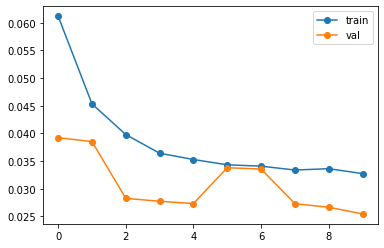

In [22]:
model_save_path = f'models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()
            
            # Propagating through the network
            output = net(x.to(device))
            
            # Calculating loss
            loss = torch.sqrt(loss_function(output, y.to(device)))
            
            # Back-Propagating the loss
            loss.backward()
            
            # Updating weights
            optimizer.step()
            
            # Accumulating the running loss
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
            
            train_loss = running_loss/len(dataloader_train)
            val_loss = compute_loss(net, dataloader_valid, loss_function, device).item()
            pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
            
            hist_loss[idx_epoch] = train_loss
            hist_loss_val[idx_epoch] = val_loss
            
            if val_loss < val_loss_best:
                val_loss_best = val_loss
                torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

## MODEL EVALUATION

In [23]:
_ = net.eval()

In [24]:
predictions = np.empty(shape=(len(dataloader_test.dataset), 24, 1))
idx_prediction = 0

with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        output = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = output
        idx_prediction += x.shape[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 90.08it/s]


In [25]:
predictions.shape

(182, 24, 1)

In [26]:
predArr = predictions.reshape(predictions.shape[0] * predictions.shape[1], predictions.shape[2]).ravel()
predArr.shape

(4368,)

In [27]:
Y_testArr = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2]).ravel().numpy()
Y_testArr.shape

(4368,)

In [28]:
def inverse_transform(df):
    column_names = df.columns
    for col in column_names:
        df[col] = ValScaler.inverse_transform(df[[col]]) 
    return df

In [29]:
comparisionDf = pd.DataFrame(data= {"Values": Y_testArr, "Predictions": predArr})
comparisionDf = inverse_transform(comparisionDf)
comparisionDf

,Values,Predictions
0,5488.580078,5311.821333
1,5476.750000,5309.293452
2,5545.419922,5344.429517
3,5443.580078,5294.973284
4,5289.070312,5303.565588
...,...,...
4363,6911.080566,6550.132223
4364,6638.850098,6464.911764
4365,6412.140625,6424.166965
4366,6451.500488,6454.832755


<AxesSubplot:>

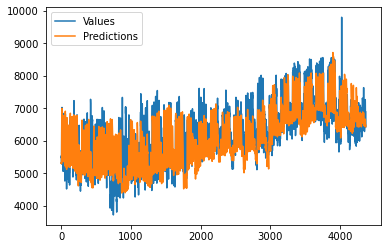

In [30]:
comparisionDf.plot()

In [31]:
mape(comparisionDf["Values"], comparisionDf["Predictions"])

4.243730974526584